# MCMC Fitting using "emcee: The MCMC Hammer"

Website: https://emcee.readthedocs.io/en/stable/

ArXiv: https://arxiv.org/abs/1202.3665

# Lets fit a line!

In [29]:
import emcee
import corner
import numpy as np
from astropy.io import ascii
from matplotlib import pyplot as plt

In [30]:
# read in mock data from file
filename = 'linefit.mockdata.txt'
data = ascii.read(filename)

In [31]:
#lets have a look at the data
data

xdata,ydata,xunc,yunc
float64,float64,float64,float64
9.89027,1.13552,0.12916,0.21744
11.91839,2.02299,0.11315,0.21007
9.65929,1.64147,0.11397,0.18853
9.90774,0.94765,0.12235,0.2157
10.25445,1.33187,0.08949,0.18246
10.99939,1.58751,0.08582,0.19437
10.5092,1.79399,0.09931,0.24522
10.9663,1.90554,0.08896,0.22689
11.06101,1.73935,0.11859,0.15621


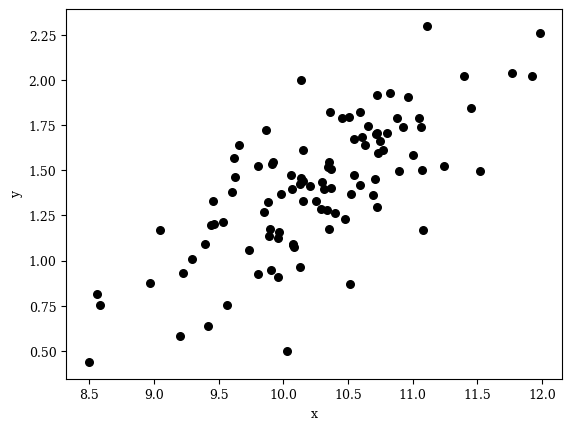

In [32]:
# display the data that we are working with
def plot_data( x, y, yunc=None, xunc=None ):
    if not yunc is None or not xunc is None :
        plt.errorbar( x, y, yunc, xunc, fmt='none', zorder=1,capsize=3 )
    plt.scatter( x, y, 30, 'k', zorder=2 )
    plt.xlabel( 'x' )
    plt.ylabel( 'y' )
    plt.draw()
    
#plot
plot_data( data['xdata'], data['ydata'] )

Text(0.5, 1.0, 'result from np.polyfit: m = 0.422847, b = -2.921065')

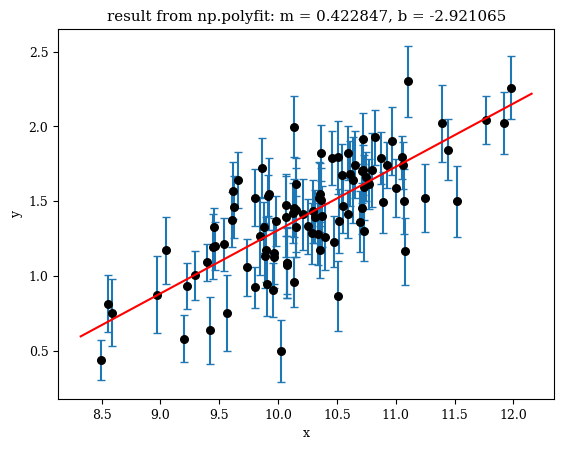

In [33]:
#do a fit using a blackbox
result = np.polyfit(data['xdata'], data['ydata'], deg=1, w=1./data['yunc']**2.)

# and now plot the data and the fit
def plot_line( result, col = 'red' ):
    plt.plot( plt.xlim(), np.polyval( result, plt.xlim() ), color=col )

plot_data( data['xdata'], data['ydata'],data['yunc'] )
plot_line( result )
plt.title( 'result from np.polyfit: m = %.6f, b = %.6f' % tuple( result ) )

Since the solution in this case is analytic (e.g. see Hogg 2010 https://arxiv.org/abs/1008.4686) lets compare the result of polyfit with the analytic results:

In [34]:
def least_squares_Yerrors(X_vals, Y_vals, Y_error):
    '''linear fit for points with yerrors and returning error of fitline
    input: all points as 1D arrays'''
    
    Y = np.matrix(Y_vals)
    C = np.zeros((X_vals.size,X_vals.size))
    A = np.matrix(np.transpose(np.array([np.ones(X_vals.size),X_vals])))
    
    np.fill_diagonal(C,Y_error**2)

    Cinv = np.linalg.inv(C)
    X = np.linalg.inv(A.T*Cinv*A)*(A.T*Cinv*Y.T)
    
    c = np.linalg.inv(A.T*Cinv*A)
    c[c<0] = np.nan
    Var = np.sqrt(c)
    return np.array([X.item(1), X.item(0), Var.item(1,1), Var.item(0,0)]) #gradient, intercept, error of gradient, ,error of intercept

# get analytic results
Analytic_results = least_squares_Yerrors(data['xdata'], data['ydata'], data['yunc'])


result from np.polyfit: m = 0.422847, b = -2.921065
result from least squares: m = 0.408418, b = -2.779802


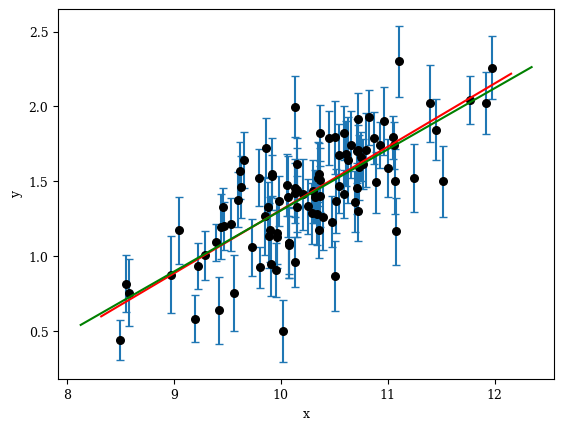

In [35]:
plot_data( data['xdata'], data['ydata'],data['yunc'] )
plot_line( result )
plot_line( Analytic_results[:2], 'green' )

print('result from np.polyfit: m = %.6f, b = %.6f' % tuple( result ) )
print('result from least squares: m = %.6f, b = %.6f' % tuple( Analytic_results[:2] ) )

Summary: be aware of blackboxes!

# Now lets use MCMC

In [36]:
# first define some functions
def log_likelihood( param_values, x, y, dy ):
    # a gaussian likelihood function. very similar to least squares
    # note for emcee it has to be in log!
    gradient, intercept = param_values
    logL = -0.5 * ( gradient * x + intercept - y )**2. /  dy**2
    return np.nansum(logL)

def lnprior(param_values):
    # a simple flat prior, requesting the values to be between +- 10
    for i in param_values:
        if (abs(i) > 100): return -np.inf
    return 0

def lnprob(param_values, x, y, dy):
    lp = lnprior(param_values) # check priors
    
    if not np.isfinite(lp):
        return -np.inf # return if not in range of prior
    
    # calc likelihood if parameters are in the range of the priors
    like = log_likelihood(param_values, x, y, dy)
    return like

def start_pos(ndim, nwalkers, start_pos_type):
    # define starting positions for walkers
    if start_pos_type  == 'gaussian': #gaussian ball around certain position
        gradient, intercept = 1, 1 
        pos = [[ gradient, intercept] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
    if start_pos_type  == 'random':  #randomly distributed within prior ranges
        pmin = np.array([-10,-10])
        pmax = np.array([10,10])
        pos = [pmin + (pmax-pmin)*np.random.rand(ndim) for i in range(nwalkers)]
    # other set ups possible
    return pos

ndim = 2 #number of free parameters
steps = 100 #number of steps
nwalkers = 5 #usually you would use ~50-100
args = [data['xdata'], data['ydata'],data['yunc'] ]
start_pos_type = 'random'
pos = start_pos(ndim, nwalkers, start_pos_type)

#set up sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)

In [37]:
#run MCMC
state = sampler.run_mcmc(pos, steps, progress=True)

100%|██████████| 100/100 [00:00<00:00, 1316.97it/s]


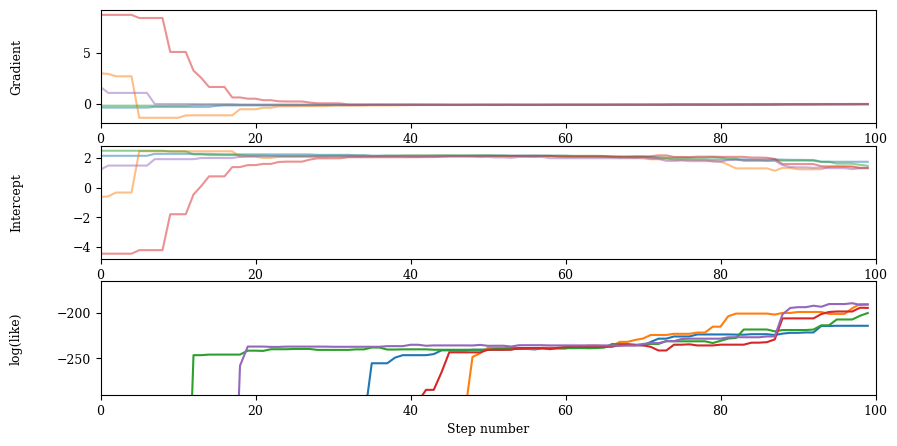

In [38]:
# plot walkers
def plot_walker(samples, like, labels):
    ndim = np.shape(samples)[-1]
    fig, axes = plt.subplots(ndim+1,figsize=(10, 5))
        
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], alpha=0.5)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    ax = axes[ndim]
    ax.set_xlim(0, len(samples))

    lim_max = np.max(like[-1,:])
    plt.ylim([lim_max-100, lim_max+25])
    ax.set_ylabel('log(like)')
    ax.plot(like[:,:])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("Step number");
    plt.show()
    
#plot
plot_walker(sampler.get_chain(), sampler.get_log_prob(), ['Gradient', 'Intercept'])

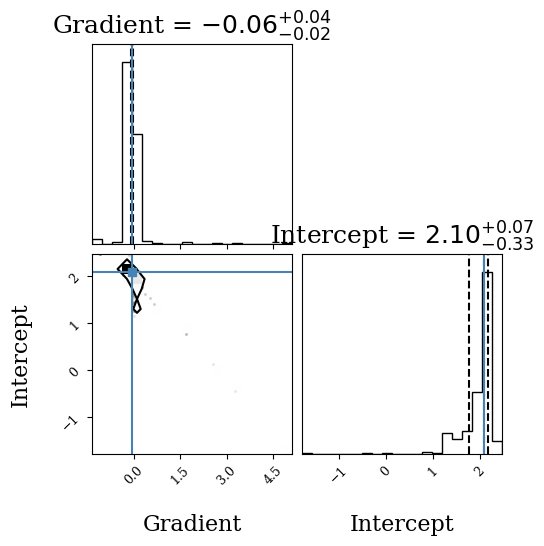

In [39]:
# plot corner
def plot_corner(sampler):
    burnin = int(np.shape(sampler.get_chain())[0]/10)
    
    samples = sampler.chain[:,  burnin:, :].reshape((-1, ndim)) 
    
    gradient, intercept = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],axis=0)))

    fig = corner.corner(samples[:,:],labels=['Gradient', 'Intercept'], truths=[gradient[0], intercept[0]], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 18},label_kwargs={"fontsize": 16}, usetex=True)
    plt.show()
    
#plot
plot_corner(sampler)

A good start, but it seems it is not finished yet. Lets continue!

In [40]:
#continue MCMC
state = sampler.run_mcmc(None, 10000, progress=True)

100%|██████████| 10000/10000 [00:05<00:00, 1920.11it/s]


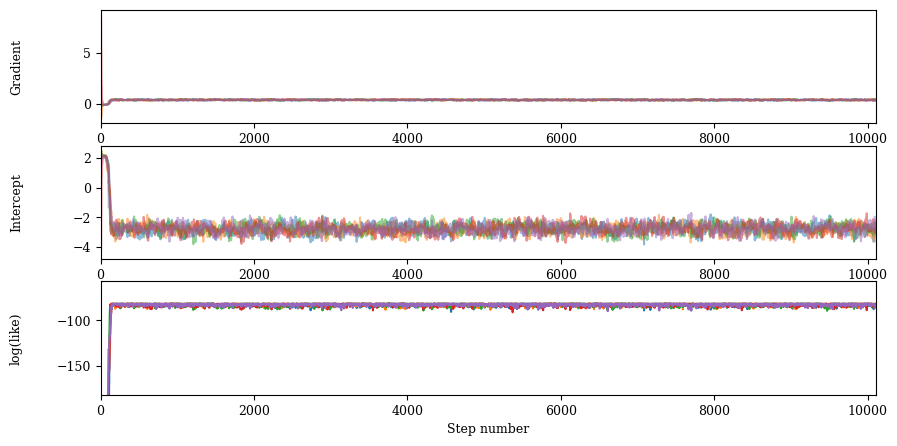

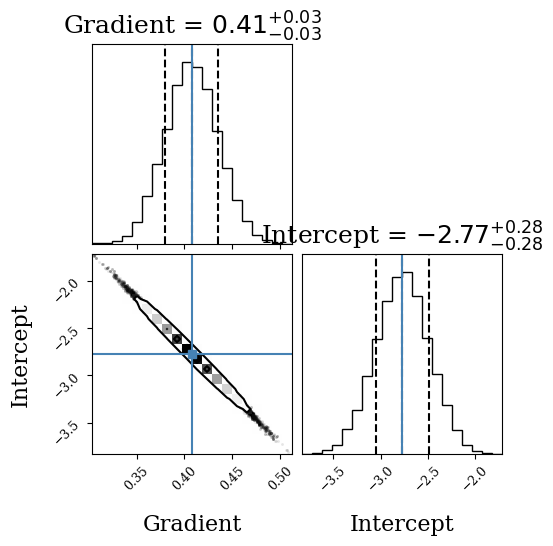

In [41]:
# plot
plot_walker(sampler.get_chain(), sampler.get_log_prob(),['Gradient', 'Intercept'])
plot_corner(sampler)

In [42]:
# get results
def get_best_fit_values(sampler):
    burnin = int(np.shape(sampler.get_chain())[0]/10) #remove firs 10% as burnin
    samples = sampler.chain[:,  burnin:, :].reshape((-1, ndim)) 
    
    gradient, intercept = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    return np.array([gradient[0], intercept[0]])
    
MCMC_results = get_best_fit_values(sampler)
print('result from np.polyfit: m = %.6f, b = %.6f' % tuple( result ) )
print('result from least squares: m = %.6f, b = %.6f' % tuple( Analytic_results[:2] ) )
print('result from MCMC: m = %.6f, b = %.6f' % tuple( MCMC_results ) )

result from np.polyfit: m = 0.422847, b = -2.921065
result from least squares: m = 0.408418, b = -2.779802
result from MCMC: m = 0.407371, b = -2.769722


### How can we validate the results? - has it converged?
-> we need to calculate the autocorrelation time tau

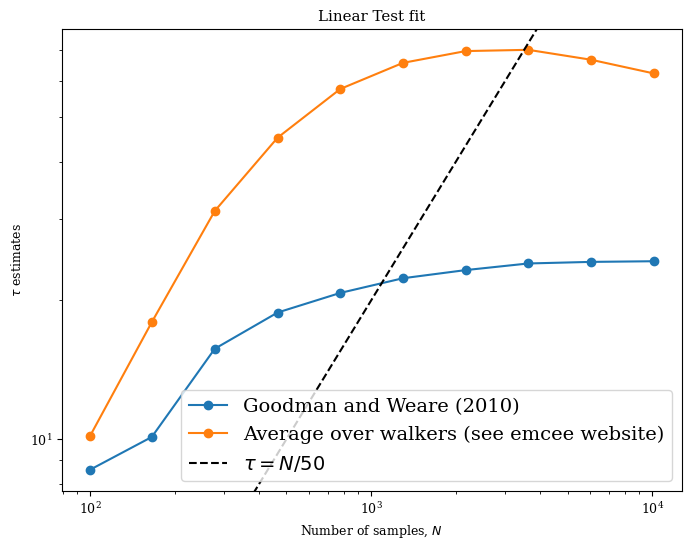

In [43]:
# calculate integrated auto-correlation function as described by the authors on the website
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

def calc_and_plot_autoccorrelation_time(chain, title='test', save_path=False):
    ''' Calculate and plot the autocorrelation time as shown on the emcee website. '''
    
    N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
    gw2010 = np.empty(len(N))
    new = np.empty(len(N))
    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(chain[:, :n])
        new[i] = autocorr_new(chain[:, :n])
      
    plot_autocorrelation_time(N, gw2010, new, title, save_path)

def plot_autocorrelation_time(N,gw2010,new,title='test',save_path=False):
    # Plot the comparisons
    plt.rcParams.update({'font.size': 9})
    plt.rc('font',family='serif')
    plt.figure(figsize=(8,6))
    plt.loglog(N, gw2010, "o-", label="Goodman and Weare (2010)")
    plt.loglog(N, new, "o-", label="Average over walkers (see emcee website)")
    ylim = plt.gca().get_ylim()
    plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    plt.ylim(ylim)
    plt.xlabel("Number of samples, $N$")
    plt.ylabel(r"$\tau$ estimates")
    plt.legend(fontsize=14)
    plt.title(title)
    if save_path != False:
        plt.savefig(save_path+title+"autocorrelation.png")  
    plt.show()

# plot    
calc_and_plot_autoccorrelation_time(sampler.get_chain()[:, :, 0].T, "Linear Test fit")

Summary: we have succesfully fitted a line and convinced ourselves that this is indeed the correct solution.

# Now with 2d-errors:

In [ ]:
def plot_covariant_data(x, y, dx, dy):
    plt.scatter( x, y,color='black')
    plt.xlabel('x')
    plt.ylabel('y')
    t = np.linspace(0, 2*np.pi, 20)
    for i in range(len(x)):
        plt.plot( x[i]+dx[i]*np.cos(t) , y[i]+dy[i]*np.sin(t),color='blue',alpha=0.5 )
#plot
plot_covariant_data(data['xdata'], data['ydata'],data['xunc'], data['yunc'])

In [ ]:
def start_pos_2dgauss(ndim, nwalkers, start_pos_type):
    # define starting positions for walkers
    x0, y0, xstd, ystd, corr = first_guess
    pos = [[ x0, y0, xstd, ystd, corr] + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]
    return pos

def log_likelihood_coverr( param_values, x, y, dx, dy, rho=0):
    # parameters describe a covariant 2d Gaussian distribution
    x0, y0, xstd, ystd, corr = param_values

    xxterm = dx * dx       + xstd * xstd
    xyterm = rho * dx * dy + corr * xstd * ystd
    yyterm = dy * dy       + ystd * ystd
    
    # construct inverse covariance matrix
    det = xxterm * yyterm - xyterm * xyterm
    icov = np.array( [[ yyterm, -xyterm],
                      [ -xyterm, xxterm ]] 
                   ) / det
    
    # and use this to compute the likelihood
    xterm, yterm = x - x0, y - y0
    logL = -0.5 * ( xterm * icov[ 0, 0 ] * xterm
                  + xterm * icov[ 0, 1 ] * yterm
                  + yterm * icov[ 1, 0 ] * xterm
                  + yterm * icov[ 1, 1 ] * yterm 
                  ) - 0.5 * np.log( det )
    
    return np.nansum( logL )

def lnprob(param_values, x, y, dx, dy):
    lp = lnprior(param_values) # check priors
    
    if not np.isfinite(lp):
        return -np.inf # return if not in range of prior
    
    # calc likelihood if parameters are in the range of the priors
    like = log_likelihood_coverr(param_values, x, y, dx, dy)
    return like

#first guess for parameters
first_guess = ( np.mean( data['xdata'] ), np.mean( data['ydata'] ), 
              np.std( data['xdata'] ), np.std( data['ydata'] ), np.corrcoef(data['xdata'], data['ydata'])[0,1] )

#some parameters
ndim = 5 #number of free parameters
steps = 1000 #number of steps
nwalkers = 20 #usually you would use ~50-100
args = [data['xdata'], data['ydata'],data['xunc'],data['yunc'] ]
start_pos_type = 'gaussian'
pos = start_pos_2dgauss(ndim, nwalkers, start_pos_type)

#set up sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)

#run MCMC
state = sampler.run_mcmc(pos, steps, progress=True)

In [ ]:
def plot_corner2dgauss(sampler):
    burnin = int(np.shape(sampler.get_chain())[0]/10) #remove firs 10% as burnin
    
    samples = sampler.chain[:,  burnin:, :].reshape((-1, ndim)) 
    
    x0, y0, xstd, ystd, corr = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],axis=0)))

    fig = corner.corner(samples[:,:],labels=['x0', 'y0', 'xstd', 'ystd', 'corr'], truths=[x0[0], y0[0], xstd[0], ystd[0], corr[0]], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 18},label_kwargs={"fontsize": 16}, usetex=True)
    plt.show()

#plot
plot_walker(sampler.get_chain(), sampler.get_log_prob(),['x0', 'y0', 'xstd', 'ystd', 'corr'])
plot_corner2dgauss(sampler)

calc_and_plot_autoccorrelation_time(sampler.get_chain()[:, :, 0].T, "2d gauss fit")

### The gaussian looks great, but how do we get our gradient and intercept values?

In [ ]:
def get_best_fit_values2dgauss(sampler):
    burnin = int(np.shape(sampler.get_chain())[0]/10) #remove first 10% as burnin
    samples = sampler.chain[:,  burnin:, :].reshape((-1, ndim)) 
    
    x0, y0, xstd, ystd, corr  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    
    return x0, y0, xstd, ystd, corr 

def get_line(x0, y0, xstd, ystd, corr):
    # get gradient and intercept values - see https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    gradient = corr[0] * ystd[0]/xstd[0]
    intercept = y0[0] - gradient*x0[0]
    return gradient, intercept

# get best fitting values
x0, y0, xstd, ystd, corr = get_best_fit_values2dgauss(sampler)
# get line
gradient, intercept = get_line(x0, y0, xstd, ystd, corr)

# plot
plot_covariant_data(data['xdata'], data['ydata'],data['xunc'], data['yunc'])
plot_line( [gradient, intercept], col = 'green' )

print('2d gaussian result from MCMC: m = %.6f, b = %.6f' % tuple( [gradient, intercept] ) )


### Additional stuff that might come in handy:

#### Emcee also works in paralell using multiprocessing (MPI is possible as well):

In [ ]:
from multiprocessing import Pool
parallel = False
if parallel:
    with Pool(cores) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args, pool=pool)
        if restart:
            state = sampler.run_mcmc(None, steps, progress=True)
        else:
            state = sampler.run_mcmc(pos, steps, progress=True)

#### Sometimes it is neccesary to reset the walkers:

In [ ]:
reset_walkers = False
if reset_walkers:
    pos, prob = state.coords, state.log_prob
    keep = ( prob.max() - prob ) < 50 # keep walkers which are within certain range of max-likelihood.
    print( f' {np.sum(keep)}/{keep.size} walkers are within range of max lnprob.' )
    if np.any( ~keep ):
        print( 'resetting walkers' )
        okay = np.mean( pos[ keep ], axis=0 )
        bump = np.std( pos[ keep ], axis=0 )            
        reroll = okay + 2.*bump*np.random.randn(nwalkers, ndim)
        pos[ ~keep ] = reroll[ ~keep ]
        sampler.reset()     
    if parallel:
        with Pool(cores) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args, pool=pool, backend=backend)
            state = sampler.run_mcmc(pos, steps_restart, progress=True)
    else:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args, backend=backend)
        state = sampler.run_mcmc(pos, steps_restart, progress=True)   
    print("Size: {0}".format(backend.iteration))